In [1]:
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from vmdpy import VMD

In [4]:
# Load the dataset
file_path = r"cleaned_data1.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Dataset not found at: {file_path}")

df = pd.read_csv(file_path)


# Ensure Date/Time is datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'], errors='coerce')
df.dropna(subset=['Date/Time'], inplace=True)

# Time features
df['hour'] = df['Date/Time'].dt.hour
df['day'] = df['Date/Time'].dt.day
df['month'] = df['Date/Time'].dt.month
df['weekday'] = df['Date/Time'].dt.weekday

# Ensure required columns
features = ['Wind Speed (m/s)', 'Wind Direction (°)', 'hour', 'day', 'month', 'weekday', 'Theoretical_Power_Curve (KWh)']
target = 'LV ActivePower (kW)'
missing_cols = [col for col in features + [target] if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in dataset: {missing_cols}")
df.dropna(subset=features + [target], inplace=True)

In [5]:
# VMD Preprocessing
def apply_vmd(signal, K=3, alpha=2000):
    # Apply VMD to a single 1D signal (e.g., wind speed)
    tau = 0.         # Noise-tolerance
    DC = 0           # No DC part
    init = 1         # Initialization
    tol = 1e-7       # Convergence tolerance

    u, _, _ = VMD(signal, alpha, tau, K, DC, init, tol)
    return u

# Decompose wind speed using VMD
wind_speed = df['Wind Speed (m/s)'].values
vmd_modes = apply_vmd(wind_speed, K=3)

# Add first 3 VMD modes as new features
for i in range(3):
    df[f'VMD_Mode_{i+1}'] = vmd_modes[i]

# Define new feature set
vmd_features = features + ['VMD_Mode_1', 'VMD_Mode_2', 'VMD_Mode_3']
X = df[vmd_features]
y = df[target]

# Add Gaussian noise to selected features
def add_gaussian_noise(data, mean=0.0, std=0.01):
    noisy_data = data.copy()
    for col in ['Wind Speed (m/s)', 'Wind Direction (°)', 'Theoretical_Power_Curve (KWh)']:
        noise = np.random.normal(mean, std, size=noisy_data[col].shape)
        noisy_data[col] += noise
    return noisy_data

X_noisy = add_gaussian_noise(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, test_size=0.3, random_state=42)

# LightGBM setup
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'random_state': 42
}

callbacks = [
    lgb.early_stopping(10),
    lgb.log_evaluation(10)
]

# Train the model
lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

# Predictions 
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1606
[LightGBM] [Info] Number of data points in the train set: 35371, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.361601
Training until validation scores don't improve for 10 rounds
[10]	train's rmse: 0.1472	valid's rmse: 0.148725
[20]	train's rmse: 0.0827847	valid's rmse: 0.0860341
[30]	train's rmse: 0.0651058	valid's rmse: 0.0694803
[40]	train's rmse: 0.057481	valid's rmse: 0.0621576
[50]	train's rmse: 0.0532569	valid's rmse: 0.058694
[60]	train's rmse: 0.0502864	valid's rmse: 0.0564998
[70]	train's rmse: 0.0482401	valid's rmse: 0.0548928
[80]	tra

In [6]:
# Evaluation
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

MSE : 0.0027
RMSE: 0.0517
MAE: 0.0231
R² Score: 0.9796


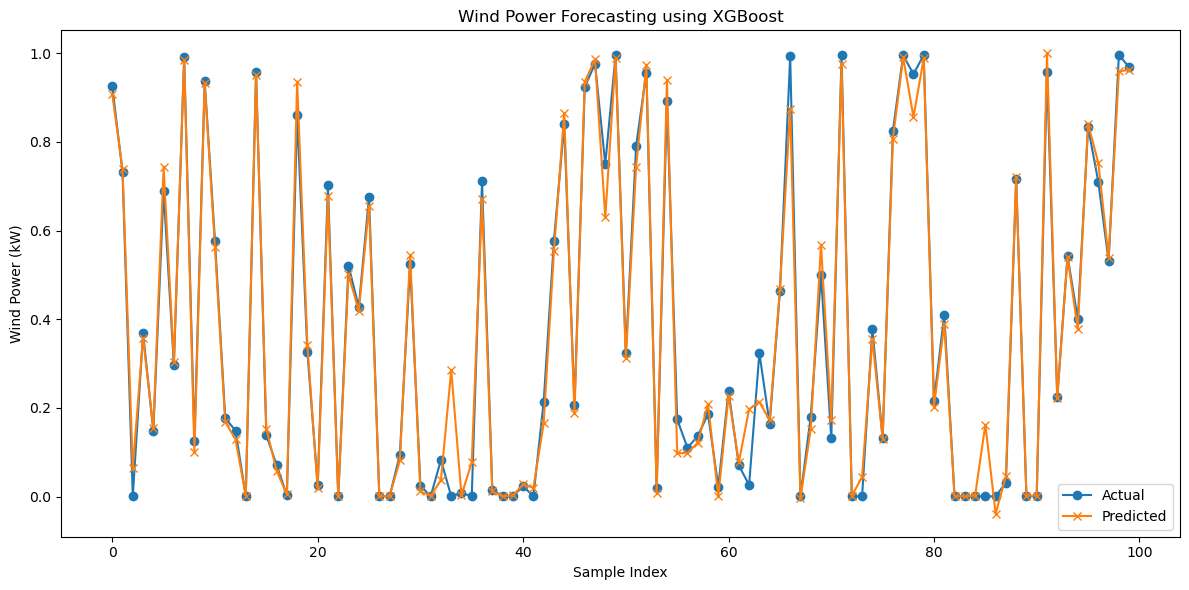

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title('Wind Power Forecasting using XGBoost')
plt.xlabel('Sample Index')
plt.ylabel('Wind Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()